# Project I | Deep Learning: Image Classification with CNN
-----

# Part 1 - Data Preprocessing
- To build a Convolutional Neural Network (CNN) model to classify images from the Animals10 dataset.

1. Data Loading
- Load the dataset (e.g., from folders or URLs)
- Split into train/validation/test sets

2. Preprocessing
- Resize images, normalize pixel values, and apply augmentations (flip, rotate, etc.)

3. Visualization
- Show sample images with labels using matplotlib


# 1. Imports and GPU Setup

In [64]:
import psutil
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


# Set all random seeds

In [65]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    # Ensure reproducible split
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# 2. Data Loading and Preprocessing

In [66]:
# Path to dataset
dataset_path = '../../data/animals10/'

# Define transformations: Resize, Augment, Convert to Tensor, Normalize
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    #transforms.RandomVerticalFlip(),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),  # <-- Must come before RandomErasing
    #transforms.RandomErasing(p=0.5),
    transforms.Normalize((0.5,), (0.5,))
])


# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

# Define split sizes
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # ensure full coverage

# Perform split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Wrap in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Output sizes
print(f"Total images: {len(dataset)}")
print(f"Training set: {len(train_dataset)}")
print(f"Validation set: {len(val_dataset)}")
print(f"Test set: {len(test_dataset)}")


Total images: 26179
Training set: 18325
Validation set: 3926
Test set: 3928


# 3. Visualize Sample Images

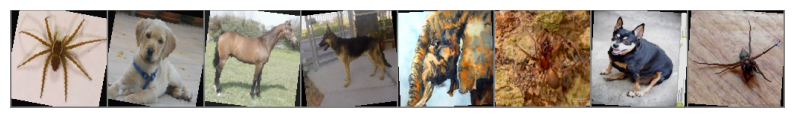

Labels: ['ragno', 'cane', 'cavallo', 'cane', 'elefante', 'ragno', 'cane', 'ragno']


In [67]:
# Show image
def imshow(img):
    img = img * 0.5 + 0.5  # Unnormalize from [-1,1] to [0,1]
    img = img.clamp(0, 1)  # Ensure values are within [0,1]
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images with labels
imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', [dataset.classes[label] for label in labels[:8]])


# 📘 Part 2 - Model Architecture

Goal:
- A CNN built from scratch using PyTorch

Include:
- Convolutional Layers
- Pooling Layers
- Fully Connected (Linear) Layers

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a Convolutional Neural Network class for animal image classification
class AnimalCNN(nn.Module):
    def __init__(self, num_classes):

        super(AnimalCNN, self).__init__()
        self.dropout = nn.Dropout(0.5)


        # ---- Convolutional Block 1 ----
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # ---- Convolutional Block 2 ----
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # ---- Convolutional Block 3 ----
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Flatten the 3D tensor into 1D for fully connected layers
        self.flatten = nn.Flatten()

        # ---- Fully Connected Layers ----
        self.fc1 = nn.Linear(128 * 16 * 16, 128) # 128 channels, 16x16 feature map

        self.fc2 = nn.Linear(128, num_classes) # Output layer

    def forward(self, x):
        # How data flows through the network
        x = self.conv_block1(x)  # First conv block
        x = self.conv_block2(x)  # Second
        x = self.conv_block3(x)  # Third
        x = self.flatten(x)      # Flatten
        x = F.relu(self.fc1(x))  # Apply ReLU activation
        x = self.dropout(x)
        x = self.fc2(x)          
        return x


# Model Initialization & Summary

In [69]:
num_classes = len(dataset.classes)
model = AnimalCNN(num_classes=num_classes) 
model.to(device)
print(model)


AnimalCNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# 🧠 Part 3 - Model Training

- Train the CNN using SGD and Adam, will pick the best one.
- Use a loss function
- Track accuracy and loss
- Add early stopping to prevent overfitting

# train_and_evaluate function:

In [70]:
def train_and_evaluate(optimizer_name, lr, batch_size, num_epochs=100, patience=4, device=device):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    import time
    start_time = time.time()

    # Detect number of classes from the dataset
    num_classes = len(dataset.classes)

    # Create model
    model = AnimalCNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_name == 'Adam' else optim.SGD(model.parameters(), lr=lr)

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # File to save the best model
    model_path = f"../../models/best_{optimizer_name}_lr{lr}_bs{batch_size}.pth"
    best_val_loss = float('inf')
    epochs_no_improve = 0

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

         # ------------------ EARLY STOPPING ------------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print("Model improved. Saving model.")
            epochs_no_improve = 0
        else:
            # No improvement → increase patience counter
            epochs_no_improve += 1
            print(f"No improvement. Early stop counter: {epochs_no_improve}/{patience}")

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break


    # Load best and test
    model.load_state_dict(torch.load(model_path))
    model.eval()
    test_preds, test_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(test_labels, test_preds)
    test_prec = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
    test_rec = recall_score(test_labels, test_preds, average='weighted')
    test_f1 = f1_score(test_labels, test_preds, average='weighted')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{optimizer_name} - Training vs Validation Loss')
    plt.legend()

    plot_path = f"../../plots/loss_curve_{optimizer_name}_lr{lr}_bs{batch_size}.png"
    plt.savefig(plot_path)

    plt.show()

    end_time = time.time()
    training_time = end_time - start_time

    # CPU usage (percentage)
    cpu_usage = psutil.cpu_percent()

    # Memory usage (MB)
    memory_info = psutil.virtual_memory()
    memory_usage = memory_info.used / (1024 ** 2)  # Convert bytes to MB

    # GPU memory usage (if CUDA is available)
    if torch.cuda.is_available():
        gpu_mem_allocated = torch.cuda.memory_allocated() / (1024 ** 2)  # MB
        gpu_mem_reserved = torch.cuda.memory_reserved() / (1024 ** 2)    # MB
    else:
        gpu_mem_allocated = 0
        gpu_mem_reserved = 0

    csv_path = f"../../results/metrics_{optimizer_name}_lr{lr}_bs{batch_size}.csv"

    results = {
        'optimizer': optimizer_name,
        'lr': lr,
        'batch_size': batch_size,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_acc': test_acc,
        'test_prec': test_prec,
        'test_rec': test_rec,
        'test_f1': test_f1,
        'model_path': model_path,
        'training_time_sec': training_time,
        'cpu_usage_percent': cpu_usage,
        'memory_usage_mb': memory_usage,
        'gpu_mem_allocated_mb': gpu_mem_allocated,
        'gpu_mem_reserved_mb': gpu_mem_reserved
    }

    # Save results to CSV
    import pandas as pd

    csv_path = f"../../results/metrics_{optimizer_name}_lr{lr}_bs{batch_size}.csv"

    pd.DataFrame([results]).to_csv(csv_path, index=False)

    return results



In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model_path, batch_size, title="Confusion Matrix", device='cpu'):
    # Load best model
    model = AnimalCNN(num_classes=len(dataset.classes)).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Prepare test loader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)

    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(title)
    plt.grid(False)
    plt.show()


Epoch 1/100 — Train Loss: 2.0173, Val Loss: 1.7352, Val Acc: 0.3859
Model improved. Saving model.
Epoch 2/100 — Train Loss: 1.7459, Val Loss: 1.6058, Val Acc: 0.4452
Model improved. Saving model.
Epoch 3/100 — Train Loss: 1.5989, Val Loss: 1.4225, Val Acc: 0.4931
Model improved. Saving model.
Epoch 4/100 — Train Loss: 1.4794, Val Loss: 1.3021, Val Acc: 0.5525
Model improved. Saving model.
Epoch 5/100 — Train Loss: 1.4014, Val Loss: 1.2446, Val Acc: 0.5795
Model improved. Saving model.
Epoch 6/100 — Train Loss: 1.3318, Val Loss: 1.2447, Val Acc: 0.5716
No improvement. Early stop counter: 1/4
Epoch 7/100 — Train Loss: 1.2899, Val Loss: 1.1582, Val Acc: 0.6182
Model improved. Saving model.
Epoch 8/100 — Train Loss: 1.2410, Val Loss: 1.1050, Val Acc: 0.6319
Model improved. Saving model.
Epoch 9/100 — Train Loss: 1.2091, Val Loss: 1.0925, Val Acc: 0.6347
Model improved. Saving model.
Epoch 10/100 — Train Loss: 1.1640, Val Loss: 1.0637, Val Acc: 0.6498
Model improved. Saving model.
Epoch 11/

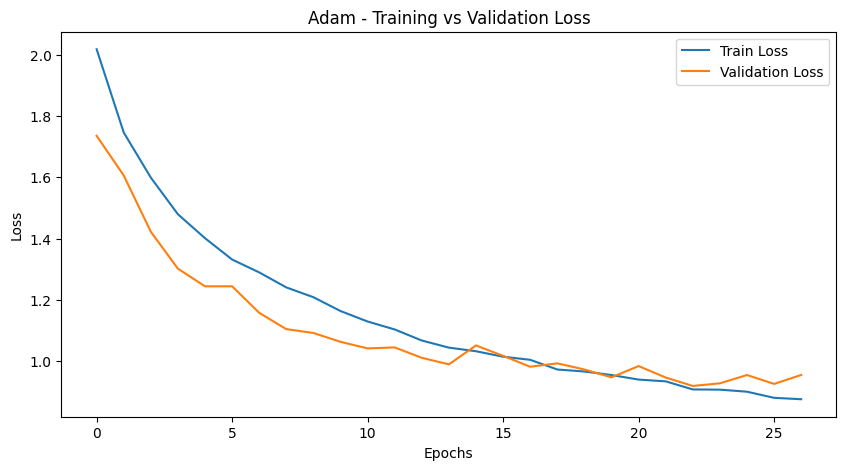

{'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 32, 'train_loss': 0.8766186977452216, 'val_loss': 0.9556697725765104, 'test_acc': 0.6830448065173116, 'test_prec': 0.6856678400576878, 'test_rec': 0.6830448065173116, 'test_f1': 0.6814086462384635, 'model_path': '../../models/best_Adam_lr0.001_bs32.pth', 'training_time_sec': 1220.9856247901917, 'cpu_usage_percent': 32.7, 'memory_usage_mb': 16466.78125, 'gpu_mem_allocated_mb': 299.24267578125, 'gpu_mem_reserved_mb': 934.0}


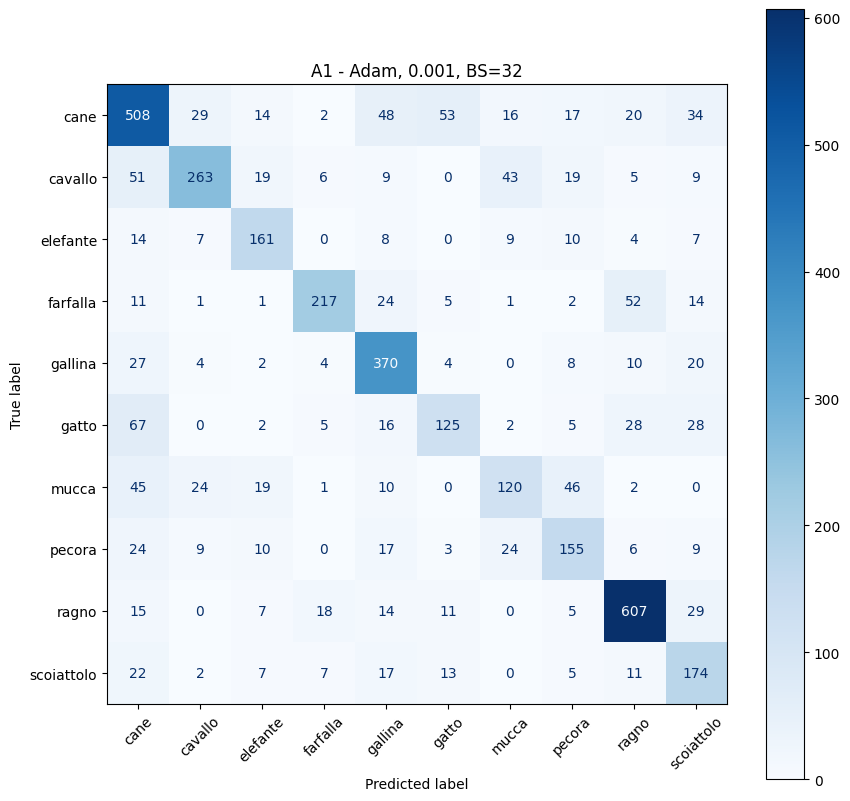

Epoch 1/100 — Train Loss: 1.9875, Val Loss: 1.6751, Val Acc: 0.4180
Model improved. Saving model.
Epoch 2/100 — Train Loss: 1.6728, Val Loss: 1.4579, Val Acc: 0.4987
Model improved. Saving model.
Epoch 3/100 — Train Loss: 1.5256, Val Loss: 1.3975, Val Acc: 0.5250
Model improved. Saving model.
Epoch 4/100 — Train Loss: 1.4462, Val Loss: 1.2647, Val Acc: 0.5672
Model improved. Saving model.
Epoch 5/100 — Train Loss: 1.3641, Val Loss: 1.2180, Val Acc: 0.5879
Model improved. Saving model.
Epoch 6/100 — Train Loss: 1.2865, Val Loss: 1.1391, Val Acc: 0.6261
Model improved. Saving model.
Epoch 7/100 — Train Loss: 1.2249, Val Loss: 1.1305, Val Acc: 0.6146
Model improved. Saving model.
Epoch 8/100 — Train Loss: 1.1654, Val Loss: 1.1412, Val Acc: 0.6154
No improvement. Early stop counter: 1/4
Epoch 9/100 — Train Loss: 1.1510, Val Loss: 1.0699, Val Acc: 0.6406
Model improved. Saving model.
Epoch 10/100 — Train Loss: 1.0960, Val Loss: 1.0808, Val Acc: 0.6347
No improvement. Early stop counter: 1/4

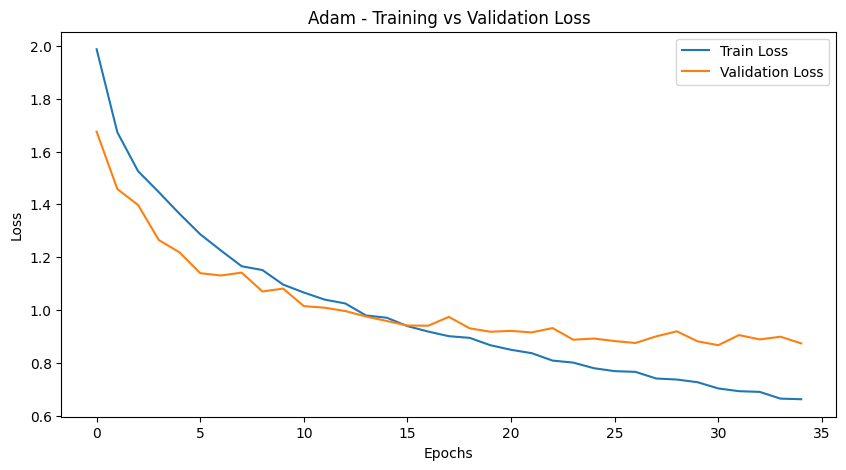

{'optimizer': 'Adam', 'lr': 0.0005, 'batch_size': 64, 'train_loss': 0.6617409532909194, 'val_loss': 0.873304687200054, 'test_acc': 0.719704684317719, 'test_prec': 0.7278042903801718, 'test_rec': 0.719704684317719, 'test_f1': 0.7153279162984348, 'model_path': '../../models/best_Adam_lr0.0005_bs64.pth', 'training_time_sec': 2500.3520979881287, 'cpu_usage_percent': 28.4, 'memory_usage_mb': 16627.984375, 'gpu_mem_allocated_mb': 299.24267578125, 'gpu_mem_reserved_mb': 1062.0}


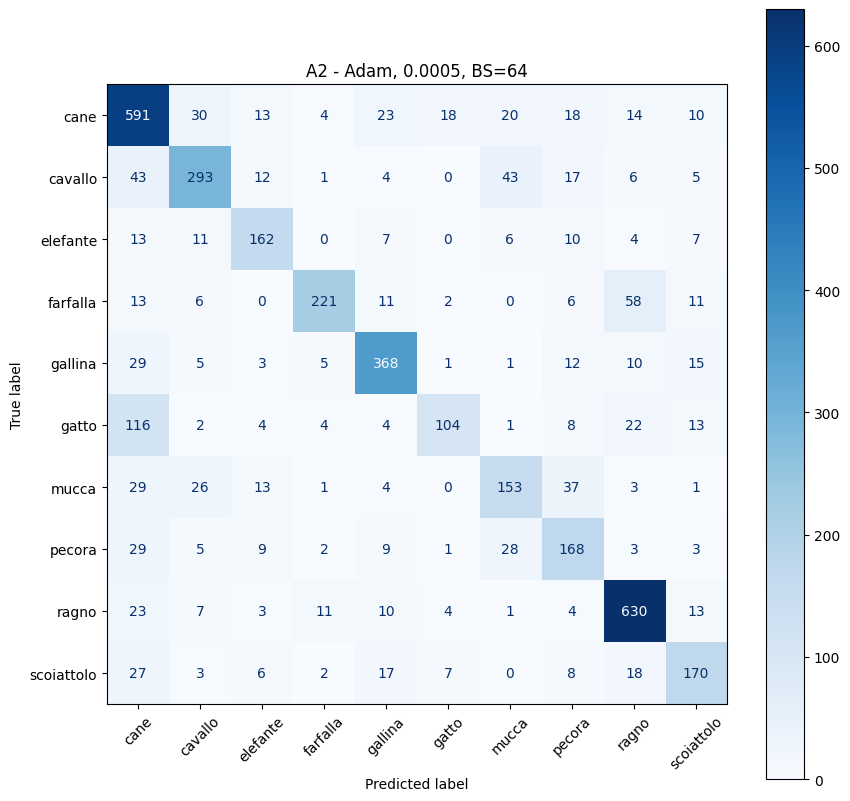

Epoch 1/100 — Train Loss: 2.1944, Val Loss: 2.1448, Val Acc: 0.2407
Model improved. Saving model.
Epoch 2/100 — Train Loss: 2.1059, Val Loss: 2.0443, Val Acc: 0.2919
Model improved. Saving model.
Epoch 3/100 — Train Loss: 2.0292, Val Loss: 1.9368, Val Acc: 0.3283
Model improved. Saving model.
Epoch 4/100 — Train Loss: 1.9529, Val Loss: 1.8705, Val Acc: 0.3497
Model improved. Saving model.
Epoch 5/100 — Train Loss: 1.8712, Val Loss: 1.7547, Val Acc: 0.3775
Model improved. Saving model.
Epoch 6/100 — Train Loss: 1.7792, Val Loss: 1.6666, Val Acc: 0.4294
Model improved. Saving model.
Epoch 7/100 — Train Loss: 1.7154, Val Loss: 1.6330, Val Acc: 0.4103
Model improved. Saving model.
Epoch 8/100 — Train Loss: 1.6596, Val Loss: 1.5569, Val Acc: 0.4710
Model improved. Saving model.
Epoch 9/100 — Train Loss: 1.6135, Val Loss: 1.4948, Val Acc: 0.4929
Model improved. Saving model.
Epoch 10/100 — Train Loss: 1.5658, Val Loss: 1.4991, Val Acc: 0.4727
No improvement. Early stop counter: 1/4
Epoch 11/

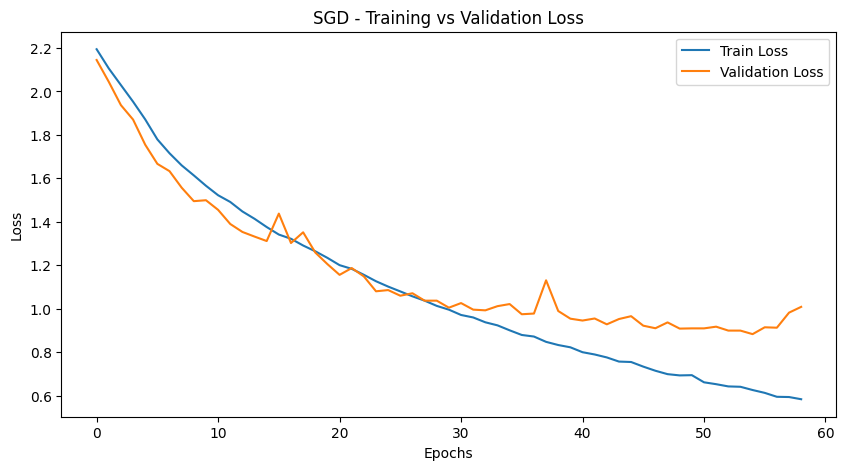

{'optimizer': 'SGD', 'lr': 0.01, 'batch_size': 32, 'train_loss': 0.5829574596559398, 'val_loss': 1.0082414731746767, 'test_acc': 0.7115580448065173, 'test_prec': 0.7125000147391838, 'test_rec': 0.7115580448065173, 'test_f1': 0.7062899029040035, 'model_path': '../../models/best_SGD_lr0.01_bs32.pth', 'training_time_sec': 2641.62225151062, 'cpu_usage_percent': 41.6, 'memory_usage_mb': 16500.7578125, 'gpu_mem_allocated_mb': 125.04296875, 'gpu_mem_reserved_mb': 1062.0}


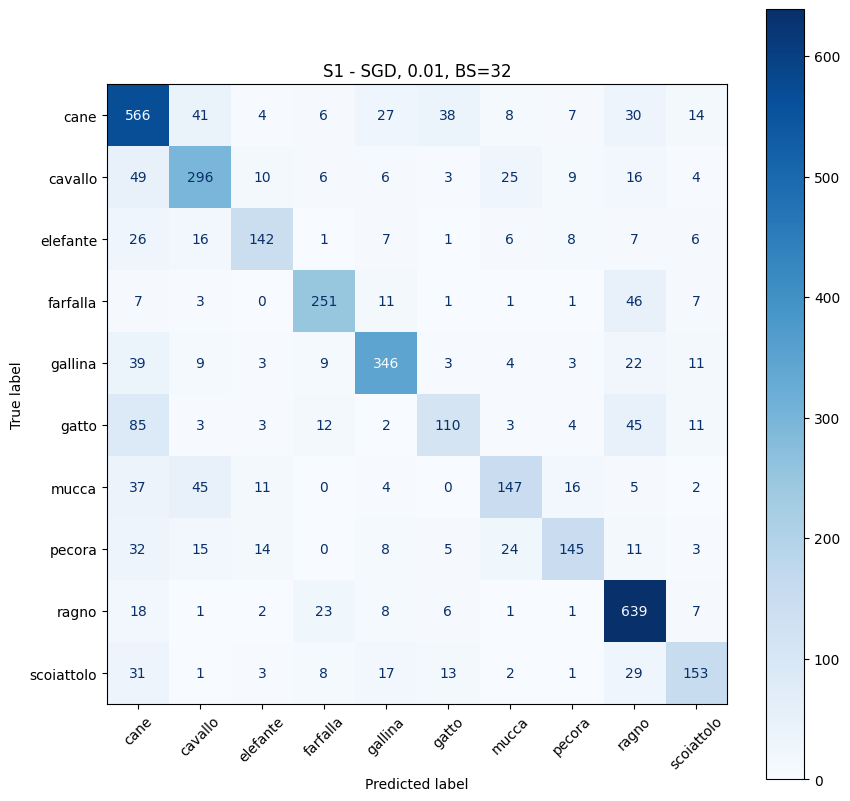

Epoch 1/100 — Train Loss: 2.2305, Val Loss: 2.2046, Val Acc: 0.2150
Model improved. Saving model.
Epoch 2/100 — Train Loss: 2.1985, Val Loss: 2.1806, Val Acc: 0.2163
Model improved. Saving model.
Epoch 3/100 — Train Loss: 2.1645, Val Loss: 2.1286, Val Acc: 0.2455
Model improved. Saving model.
Epoch 4/100 — Train Loss: 2.1144, Val Loss: 2.0605, Val Acc: 0.2792
Model improved. Saving model.
Epoch 5/100 — Train Loss: 2.0608, Val Loss: 1.9993, Val Acc: 0.3095
Model improved. Saving model.
Epoch 6/100 — Train Loss: 2.0000, Val Loss: 1.9273, Val Acc: 0.3281
Model improved. Saving model.
Epoch 7/100 — Train Loss: 1.9405, Val Loss: 1.8645, Val Acc: 0.3490
Model improved. Saving model.
Epoch 8/100 — Train Loss: 1.8866, Val Loss: 1.8318, Val Acc: 0.3474
Model improved. Saving model.
Epoch 9/100 — Train Loss: 1.8480, Val Loss: 1.7652, Val Acc: 0.3872
Model improved. Saving model.
Epoch 10/100 — Train Loss: 1.8023, Val Loss: 1.7301, Val Acc: 0.4035
Model improved. Saving model.
Epoch 11/100 — Trai

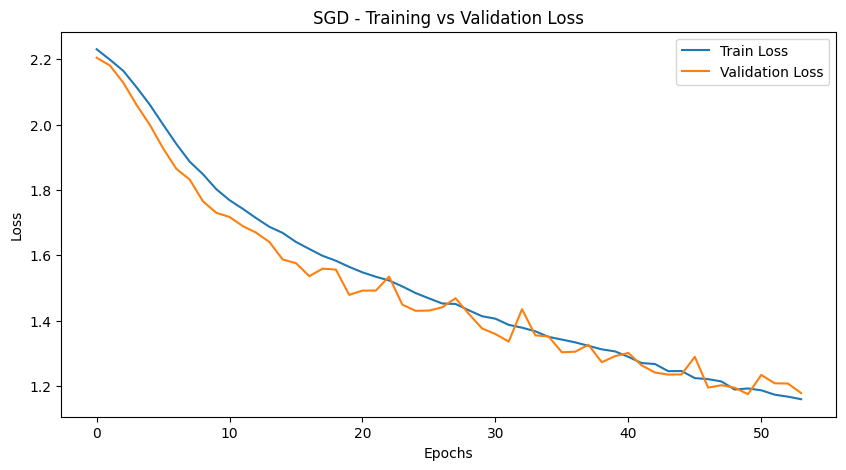

{'optimizer': 'SGD', 'lr': 0.005, 'batch_size': 64, 'train_loss': 1.1597433345658439, 'val_loss': 1.1783980592604606, 'test_acc': 0.5962321792260692, 'test_prec': 0.5951211501578212, 'test_rec': 0.5962321792260692, 'test_f1': 0.5822912604466773, 'model_path': '../../models/best_SGD_lr0.005_bs64.pth', 'training_time_sec': 3857.662456035614, 'cpu_usage_percent': 28.5, 'memory_usage_mb': 16605.98046875, 'gpu_mem_allocated_mb': 126.04296875, 'gpu_mem_reserved_mb': 1062.0}


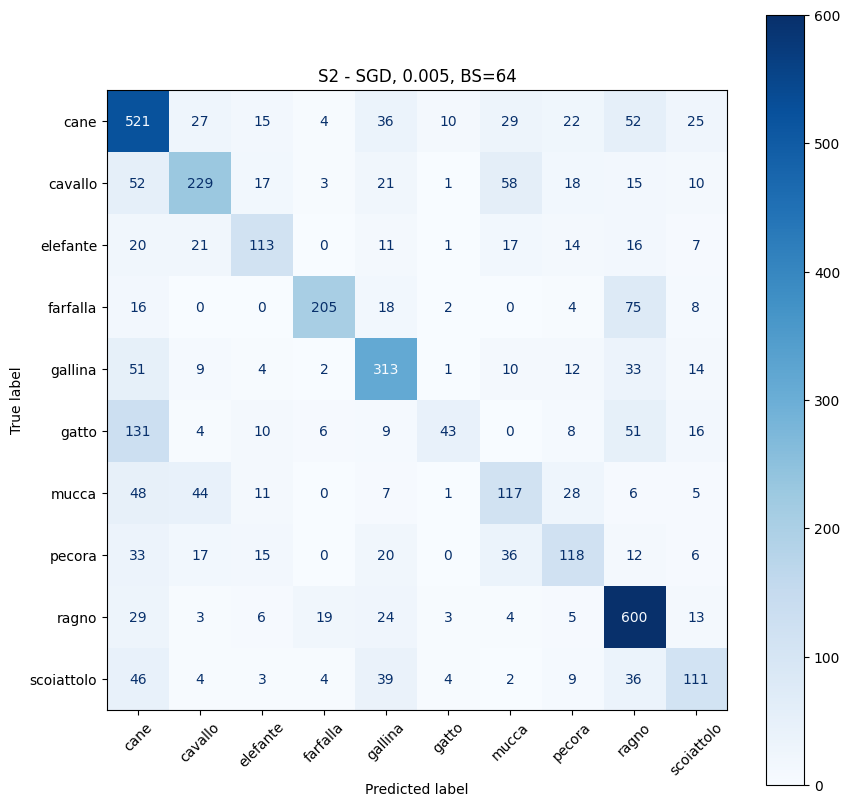

In [72]:
# Run first experiment
set_seed(42)

result_A1 = train_and_evaluate('Adam', 0.001, 32, device=device)
print(result_A1)
plot_confusion_matrix(result_A1['model_path'], 32, title='A1 - Adam, 0.001, BS=32', device=device)

# Run all other experiments with confusion matrix
result_A2 = train_and_evaluate('Adam', 0.0005, 64, device=device)
print(result_A2)
plot_confusion_matrix(result_A2['model_path'], 64, title='A2 - Adam, 0.0005, BS=64', device=device)

result_S1 = train_and_evaluate('SGD', 0.01, 32, device=device)
print(result_S1)
plot_confusion_matrix(result_S1['model_path'], 32, title='S1 - SGD, 0.01, BS=32', device=device)

result_S2 = train_and_evaluate('SGD', 0.005, 64, device=device)
print(result_S2)
plot_confusion_matrix(result_S2['model_path'], 64, title='S2 - SGD, 0.005, BS=64', device=device)


